# PMFG -- Centrality Measures Analysis
#### M Chu
Adapted from `playground.ipynb`.

In [1]:
import numpy as np
import pandas as pd
import networkx as nx

from PMFG import PMFG

from time import time
import timeit

#%matplotlib inline
import matplotlib.pyplot as plt

## Importing data

In [2]:
raw_asset_prices_df = pd.read_csv("IVV_historical.csv", index_col='Date')
log_returns_df = np.log(raw_asset_prices_df).diff().dropna()
# drop first row of raw prices so it has the same dimensions as the log-returns DF
raw_asset_prices_df = raw_asset_prices_df.iloc[1:]
stock_names = log_returns_df.columns

df_shape = (raw_asset_prices_df.shape)
print(f"There are {df_shape[0]} rows and {df_shape[1]} columns in the dataset.")
print(f"Data timeperiod covers: {raw_asset_prices_df.index[0]} to {raw_asset_prices_df.index[-1]}")

log_returns_df.head()

There are 251 rows and 504 columns in the dataset.
Data timeperiod covers: 2020/6/22 to 2021/6/18


,AAPL,MSFT,AMZN,FB,GOOGL,GOOG,JPM,TSLA,JNJ,UNH,...,UNM,NOV,PRGO,RL,FOX,DISCA,HFC,UAA,UA,NWS
Date,,,,,,,,,,,,,,,,,,,,,
2020/6/22,0.025827,0.027395,0.014404,0.001799,0.018099,0.013969,-0.010896,-0.006596,-0.003064,0.004898,...,-0.004257,0.005945,0.005634,0.026948,-0.007939,-0.014094,-0.015945,0.000000,-0.002328,0.009217
2020/6/23,0.021120,0.006659,0.018470,0.012545,0.009140,0.008607,0.012123,0.007475,-0.003703,0.016705,...,0.000609,0.026735,-0.001995,0.001635,0.007580,0.014546,-0.007910,0.036142,0.039983,0.006650
2020/6/24,-0.017810,-0.020363,-0.010915,-0.034522,-0.021598,-0.022401,-0.033961,-0.041715,-0.021509,-0.028701,...,-0.057015,-0.080661,-0.020547,-0.039003,-0.029188,-0.020055,-0.062254,-0.040357,-0.039983,-0.031989
2020/6/25,0.013188,0.012557,0.007353,0.007068,0.005846,0.006515,0.034268,0.025818,-0.001073,0.024053,...,0.052743,0.093765,0.014354,-0.004682,-0.009673,-0.021406,0.002026,0.013634,0.010435,0.006820
2020/6/26,-0.031208,-0.020219,-0.022657,-0.086826,-0.056056,-0.058155,-0.056378,-0.026974,-0.013407,-0.032038,...,-0.052098,-0.008170,-0.014540,-0.037970,-0.038100,-0.048179,-0.049448,-0.052390,-0.048444,-0.019735


## Construction of correlation matrix

In [3]:
raw_corr = log_returns_df.corr()

shr_coef = 1e-4
#shr_target=np.ones((df_shape[1], df_shape[1]))
shr_target=np.eye(df_shape[1])

correlation_matrix = raw_corr*(1-shr_coef) + shr_target*shr_coef
print('Condition number of sample correlation matrix: %.2e' %np.linalg.cond(raw_corr))
print('Condition number of shrunk correlation matrix: %.2e' %np.linalg.cond(correlation_matrix))
correlation_matrix.head()

Condition number of sample correlation matrix: 1.13e+19
Condition number of shrunk correlation matrix: 1.49e+06


,AAPL,MSFT,AMZN,FB,GOOGL,GOOG,JPM,TSLA,JNJ,UNH,...,UNM,NOV,PRGO,RL,FOX,DISCA,HFC,UAA,UA,NWS
AAPL,1.000000,0.694200,0.691205,0.634493,0.522702,0.512583,0.029423,0.492938,0.220624,0.205805,...,0.025386,-0.016511,0.115755,-0.015630,0.113051,0.024639,0.014589,-0.048178,-0.046476,0.174052
MSFT,0.694200,1.000000,0.741015,0.608564,0.717165,0.705709,0.040791,0.500559,0.284647,0.324833,...,-0.011969,-0.025407,0.099012,-0.058433,0.072387,-0.047254,-0.014123,-0.063651,-0.067568,0.198791
AMZN,0.691205,0.741015,1.000000,0.688021,0.622603,0.626005,-0.070769,0.478916,0.109943,0.217174,...,-0.123943,-0.089610,-0.038883,-0.092398,0.002334,-0.070554,-0.108014,-0.055348,-0.060529,0.113214
FB,0.634493,0.608564,0.688021,1.000000,0.658567,0.657867,0.020714,0.349706,0.187031,0.319269,...,-0.031311,-0.046235,0.007846,-0.037580,0.074092,0.007478,-0.002316,0.010992,0.011035,0.176672
GOOGL,0.522702,0.717165,0.622603,0.658567,1.000000,0.993162,0.189587,0.377768,0.281600,0.377338,...,0.127267,0.168430,0.140180,0.083248,0.154922,0.043158,0.147497,0.181127,0.186247,0.266149


### Robust Correlation
Weighted correlation, with exponential decay. Needs an additional parameter choice $\theta$; here, $\theta=\tau=126.$

In [4]:
from statsmodels.stats.weightstats import DescrStatsW

sample_window = 126
#theta = 10
theta  = sample_window
ts = np.array([t - sample_window + 1 for t in range(sample_window)])
exp_decay_weights = np.exp(ts/theta)
exp_decay_weights = exp_decay_weights/np.sum(exp_decay_weights)

w_stats = DescrStatsW(log_returns_df.iloc[:sample_window], weights=exp_decay_weights)
np.linalg.cond(w_stats.corrcoef)

use_weighted_corr = False

if use_weighted_corr:
    correlation_matrix = w_stats.corrcoef*(1-shr_coef) + shr_target*shr_coef
    # diagonal is sometimes $1-\epsilon$ due to numerical imprecisions
    np.fill_diagonal(correlation_matrix, 1)
    # Need to double check this line -- no guarantee if stock ordering is
    # preserved after plugging it into statsmodels.DescrStatsW
    correlation_matrix = pd.DataFrame(correlation_matrix, columns=stock_names, index=stock_names)
    print('Condition number of exp-decay corr mat, BEFORE regularization: %.2e' %np.linalg.cond(w_stats.corrcoef))
    print('Condition number of exp-decay corr mat, AFTER shrinkage: %.2e' %np.linalg.cond(correlation_matrix))
    correlation_matrix.head()

## Graph construction and centrality/peripherality measures
Interestingly, from Pozzi et al., they used different edge weights for each centrality/peripherality meaures.

Pipeline:

1. Construct correlation matrix (for each tick, say, daily data)
    * Robust est. and shrinkage sorely needed
2. Use (off-diagonal) corr. as adjacency matrix;  construct MST/PMFG.etc
3. transform edge weights
    * $R_{ij} \mapsto 1+R_{ij}$ for Deg and Eig-Centrality
    * $R_{ij} \mapsto \sqrt{2(1-R_{ij})}$ for BC, Closeness, and Eccentricity
    * Can also make the graph unweighted; Pozzi reported similar results for weighted/unweighted graphs
4. report centrality/peripherality measures for each node
    * Betweeness-centrality, eccentricity .etc
5. Aggregate the measures; analyze and compose hybrid cen/per index



In [5]:
G0 = nx.from_pandas_adjacency(correlation_matrix-np.diag(np.diag(correlation_matrix)))
print(nx.info(G0))
print('Sanity check: edge weights are non-binary...')
nx.adjacency_matrix(G0)[0,1]
#nx.draw(G0, with_labels=True, node_size=700, node_color="#e1575c", edge_color='#363847',  pos=nx.spectral_layout(Gt1))

Name: 
Type: Graph
Number of nodes: 504
Number of edges: 126756
Average degree: 503.0000
Sanity check: edge weights are non-binary...


0.694200351385983

In [6]:
timestamp = time()
G0_filtered = PMFG(G0).compute()
print('Time taken to construct PMFG graph: %.2f s\n' %(time()-timestamp))
print(nx.info(G0_filtered))

# check that the MST is weighted:
#G0_filtered.edges('AAPL')
G0_filtered.adj['AAPL']

Time taken to construct PMFG graph: 103.82 s

Name: 
Type: Graph
Number of nodes: 504
Number of edges: 1506
Average degree:   5.9762


AtlasView({'MSFT': {'weight': 0.694200351385983}, 'AMZN': {'weight': 0.6912045284814897}, 'FB': {'weight': 0.6344928826693308}, 'TWTR': {'weight': 0.37563356214461063}})

Centrality/peripherality measures: 
* degree 
* betweenness-centrality
* eccentricity
* closeness
* eigenvector-centrality

In [7]:
print('Testing runtime for graph operations:')

print('\nDegree')
%timeit nx.degree(G0_filtered)
print('\nBetweenness Centrality')
%timeit nx.betweenness_centrality(G0_filtered)
print('\nEccentricity')
%timeit nx.eccentricity(G0_filtered)
print('\nCloseness')
%timeit nx.closeness_centrality(G0_filtered)
print('\nEigenvector Centrality')
%timeit nx.eigenvector_centrality(G0_filtered)

#print('\nMST construction from correlation')
#%timeit nx.minimum_spanning_tree(G0)
# PMFG construction??
# planarity check using planarity.py? (should be way faster)
#print('Check Planarity (of original/dense graph)')
#%timeit nx.check_planarity(G0)

Testing runtime for graph operations:

Degree
941 ns ± 2.9 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)

Betweenness Centrality
765 ms ± 3.76 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Eccentricity
269 ms ± 5.81 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Closeness
267 ms ± 2.37 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Eigenvector Centrality
69.4 ms ± 250 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [46]:
G1 = nx.Graph()
weight_map = lambda w: 1+w
for u,v,d in G0_filtered.edges(data=True):
    G1.add_edge(u,v,weight=weight_map(d['weight']))
print(nx.info(G1))

deg= pd.DataFrame.from_dict(dict(G1.degree(weight='weight')), orient='index', columns = ['D'])
# for eigen-centrality, can tune max_iter and weight=None/'weight'
# so far, no noticeable by tuning these params
#EC = pd.DataFrame.from_dict(nx.eigenvector_centrality(G1, weight='weight'), orient='index', columns = ['EC'])
EC = pd.DataFrame.from_dict(nx.eigenvector_centrality(G1), orient='index', columns = ['EC'])


Name: 
Type: Graph
Number of nodes: 504
Number of edges: 1506
Average degree:   5.9762


In [47]:
# params to tune: alpha, max_iter, tolerance
# also personalization (which defaults to uniform/zero) and 
# dangling-mapping (which defaults to personalization)
PG =  pd.DataFrame.from_dict(nx.pagerank(G1), orient='index', columns = ['PG'])

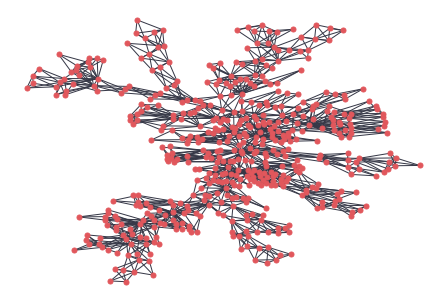

In [10]:
#nx.draw(G1, with_labels=False, node_size=25, node_color="#e1575c", edge_color='#363847',  pos=nx.fruchterman_reingold_layout(G1))
nx.draw(G1, with_labels=False, node_size=25, node_color="#e1575c", edge_color='#363847',  pos=nx.kamada_kawai_layout(G1))

#nx.draw(G1, with_labels=False, node_size=25, node_color="#e1575c", edge_color='#363847',  pos=nx.spring_layout(G1, iterations=500))

In [48]:
G1 = nx.Graph()
weight_map = lambda w: np.sqrt(2*(1-w))
for u,v,d in G0_filtered.edges(data=True):
    G1.add_edge(u,v,weight=weight_map(d['weight']))
print(nx.info(G1))

ecc= pd.DataFrame.from_dict(nx.eccentricity(G1), orient='index', columns = ['E'])
clo= pd.DataFrame.from_dict(nx.closeness_centrality(G1), orient='index', columns = ['C'])
BC = pd.DataFrame.from_dict(nx.betweenness_centrality(G1), orient='index', columns = ['BC'])

Name: 
Type: Graph
Number of nodes: 504
Number of edges: 1506
Average degree:   5.9762


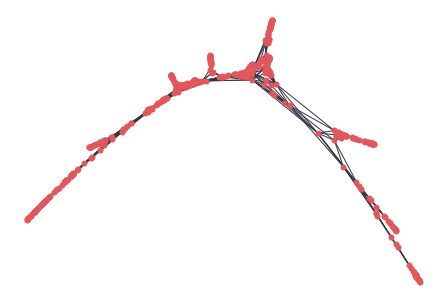

In [12]:
#nx.draw(G1, with_labels=False, node_size=25, node_color="#e1575c", edge_color='#363847',  pos=nx.fruchterman_reingold_layout(G1))
#nx.draw(G1, with_labels=False, node_size=25, node_color="#e1575c", edge_color='#363847',  pos=nx.kamada_kawai_layout(G1))
nx.draw(G1, with_labels=False, node_size=25, node_color="#e1575c", edge_color='#363847',  pos=nx.spectral_layout(G1))

#nx.draw(G1, with_labels=False, node_size=25, node_color="#e1575c", edge_color='#363847',  pos=nx.spring_layout(G1, iterations=500))

In [50]:
#centralities_names = ['BC', 'C', 'D', 'E', 'EC']
#centralities_names = ['D', 'BC', 'E', 'C', 'EC']
centralities_names = ['D', 'BC', 'nE', 'C', 'EC', 'PG']

centralities = deg.copy()
centralities['BC'] = BC
centralities['nE']  = -ecc
centralities['C']  = clo
centralities['EC'] = EC
centralities['PG'] = PG

print(centralities.head())

               D        BC  nE         C        EC        PG
GOOGL   8.474581  0.000039 -15  0.118520  0.001310  0.001810
GOOG    5.356738  0.000000 -15  0.118047  0.000624  0.001231
MSFT   24.632331  0.029563 -14  0.133670  0.003768  0.004749
FB     12.930859  0.001579 -15  0.118604  0.001545  0.002683
ADBE   36.431666  0.031345 -14  0.133955  0.006840  0.006846


In [51]:
centralities.corr()

,D,BC,nE,C,EC,PG
D,1.000000,0.784746,0.173614,0.304541,0.612575,0.994785
BC,0.784746,1.000000,0.196155,0.339132,0.647933,0.761502
nE,0.173614,0.196155,1.000000,0.938179,0.622113,0.140919
C,0.304541,0.339132,0.938179,1.000000,0.748223,0.257244
EC,0.612575,0.647933,0.622113,0.748223,1.000000,0.588855
PG,0.994785,0.761502,0.140919,0.257244,0.588855,1.000000


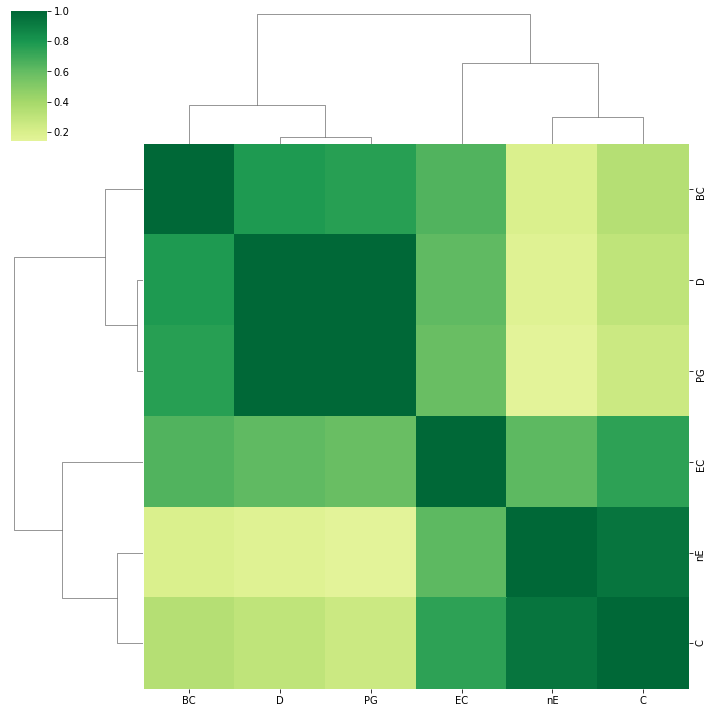

In [52]:
import seaborn as sns

sns.clustermap(centralities.corr(), cmap="RdYlGn", center=0.)
plt.show()

In [53]:
BC.idxmax()

BC    EMR
dtype: object

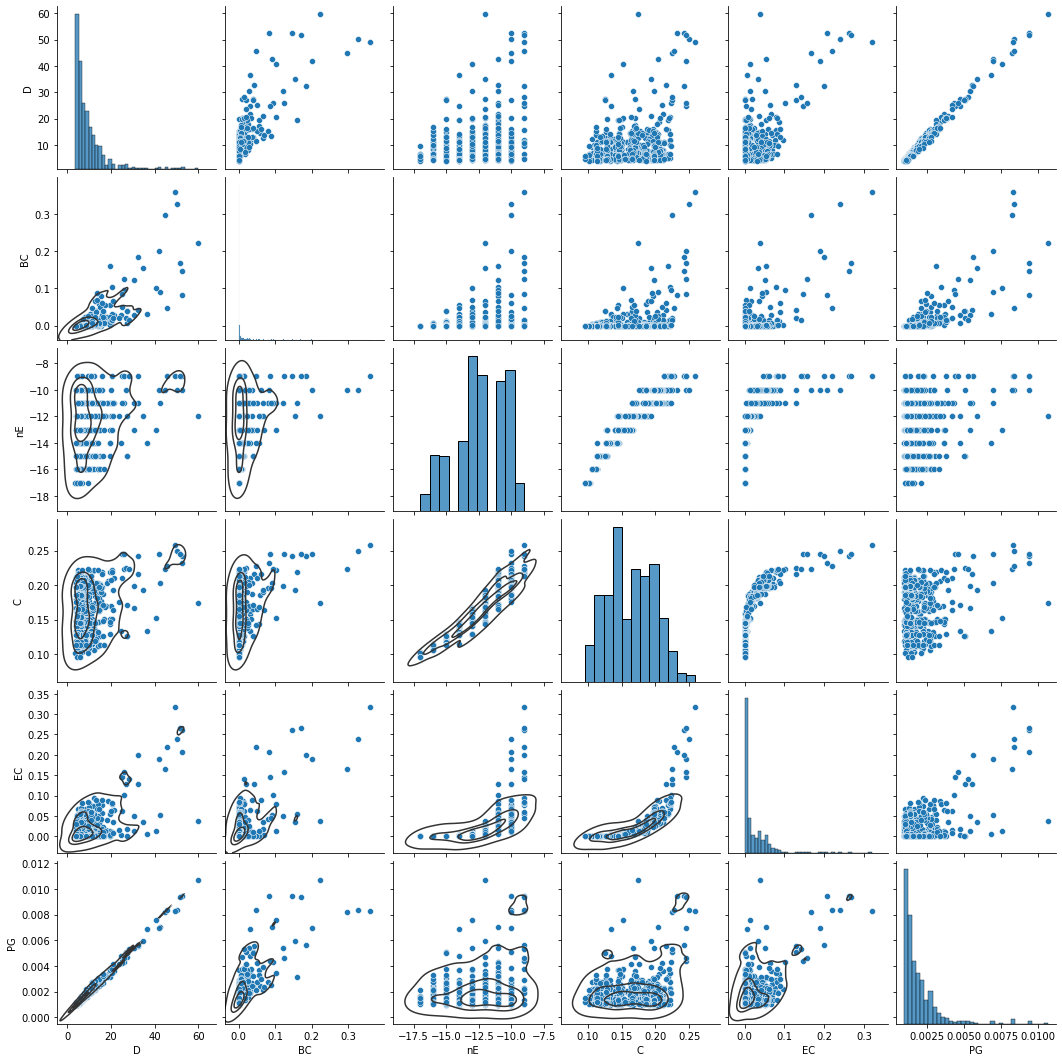

In [54]:
corr_plot = sns.pairplot(data=centralities);

corr_plot.map_lower(sns.kdeplot, levels=4, color=".2");

## Use D/BC/E/C/EC as features
Attempted to use these node properties as features and visualize them. Excluded the outlier ($CLX) a.k.a. the root-node of the min-spanning tree.

Using some embedding methods to visualize these features:

Explained variance by first two PCs:
[0.62400491 0.28262962]
First two PCs:
['D', 'BC', 'nE', 'C', 'EC', 'PG']
[[ 0.43880883  0.4209262   0.31178161  0.37297301  0.46111511  0.42582175]
 [ 0.36807311  0.28159254 -0.58451519 -0.51465489 -0.15792897  0.39212065]]
D : 0.439 | 0.368
BC : 0.421 | 0.282
nE : 0.312 | -0.585
C : 0.373 | -0.515
EC : 0.461 | -0.158
PG : 0.426 | 0.392


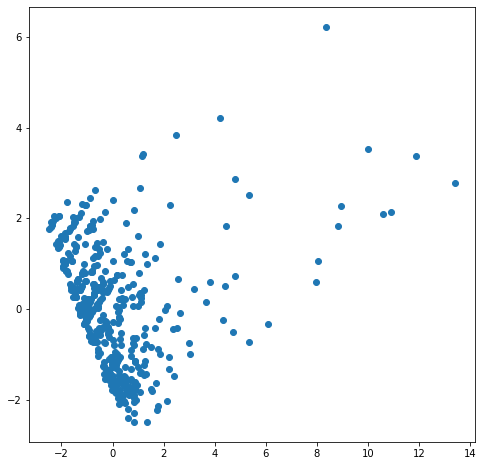

In [55]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale

# preprocess the data to have zero mean and unit var.
# (or do i have to normalize by L2/L1?)
#cen = scale(cen_noout)      # excludes the root-node ($CLX)
cen = scale(centralities)
pca = PCA(n_components=2)
pca.fit(cen)

print('Explained variance by first two PCs:')
print(pca.explained_variance_ratio_)
print('First two PCs:')
print(centralities_names)
print(pca.components_)

for cname, pc1, pc2 in zip(centralities_names, pca.components_[0],  pca.components_[1]):
    print(cname, ': %.3f | %.3f' %(pc1, pc2))
    
DR = pca.transform(cen)
plt.figure(figsize=(8,8))
plt.scatter(DR[:,0], DR[:,1]);

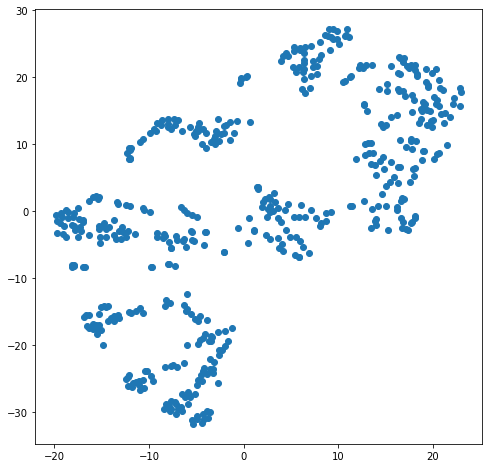

In [56]:
perp = 30
n_iter = 2000           # default = 1000
tsne = TSNE(n_components=2, perplexity=perp, n_iter=n_iter)
DR = tsne.fit_transform(cen)

plt.figure(figsize=(8,8))
plt.scatter(DR[:,0], DR[:,1]);